In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rapidfuzz import fuzz
from tabulate import tabulate
from Levenshtein import distance as levenshtein

In [ ]:
data={
    'ID':[1,2,3,4,5],
    'Name': ['Vladyslav Tataryn','V. Tataryn','Wladyslaw Tataryn','Tataryn Vladyslav','Vladslv Tataryn'],
    'Organisation':['Oschadbank','National Oshchadnyi bank of Ukraine','Oshchad','Bank','OshchadBank'],
    'Product':['Google Pixel 8 Obsidian','Pixel 8 black','G. pixel 8 Obsidian','picksel eight black','pixel 8 black']
}
df=pd.DataFrame(data)
df

,ID,Name,Organisation,Product
0,1,Vladyslav Tataryn,Oschadbank,Google Pixel 8 Obsidian
1,2,V. Tataryn,National Oshchadnyi bank of Ukraine,Pixel 8 black
2,3,Wladyslaw Tataryn,Oshchad,G. pixel 8 Obsidian
3,4,Tataryn Vladyslav,Bank,picksel eight black
4,5,Vladslv Tataryn,OshchadBank,pixel 8 black


### Using Soundex for phonetic similarity

In [ ]:
def soundex(name):
    name=name.upper()
    name=''.join([char for char in name if char.isalpha()])
    soundex_code=name[0]
    soundex_dict={
        'A': '0', 'B': '1', 'C': '2', 'D': '3', 'E': '0', 'F': '1', 'G': '2',
        'H': '0', 'I': '0', 'J': '2', 'K': '2', 'L': '4', 'M': '5', 'N': '5',
        'O': '0', 'P': '1', 'Q': '2', 'R': '6', 'S': '2', 'T': '3', 'U': '0',
        'V': '1', 'W': '0', 'X': '2', 'Y': '0', 'Z': '2'
    }
    prev_digit=None
    for char in name[1:]:
        digit=soundex_dict.get(char,'0')
        if digit!=prev_digit:
            soundex_code+=digit
        prev_digit=digit
    soundex_code=soundex_code[:4].ljust(4, '0')
    return soundex_code

In [4]:
def soundex_similarity(str1,str2):
    return int(soundex(str1)==soundex(str2))*100

### Using Levenshtein distance

In [5]:
def levenshtein_distance(str1,str2):
    return levenshtein(str1,str2)

In [6]:
def calculate_similarity(name_jw,name_soundex,org_jw,org_soundex,prod_jw,prod_soundex):
    return round((name_jw*0.4+name_soundex*0.1+
                  org_jw*0.2+org_soundex*0.1+
                  prod_jw*0.15+prod_soundex*0.05),2)

#### Comparing

In [ ]:
def create_comparison_table(df, threshold=75):
    results = []

    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            name_jw=fuzz.token_sort_ratio(df.loc[i,'Name'],df.loc[j,'Name'])/100
            name_soundex=soundex_similarity(df.loc[i,'Name'],df.loc[j,'Name'])/100
            org_jw=fuzz.token_sort_ratio(df.loc[i,'Organisation'],df.loc[j,'Organisation'])/100
            org_soundex=soundex_similarity(df.loc[i,'Organisation'],df.loc[j,'Organisation'])/100
            prod_jw=fuzz.token_sort_ratio(df.loc[i,'Product'],df.loc[j,'Product'])/100
            prod_soundex=soundex_similarity(df.loc[i,'Product'],df.loc[j,'Product'])/100
            distance=levenshtein_distance(df.loc[i,'Name'],df.loc[j,'Name'])
            probability=calculate_similarity(name_jw,name_soundex,org_jw,org_soundex,prod_jw,prod_soundex)
            decision="Belong" if probability*100>=threshold else "Dont belong"

            results.append([
                df.loc[i,'ID'],df.loc[j,'ID'],
                df.loc[i,'Name'],df.loc[j,'Name'],
                df.loc[i,'Organisation'],df.loc[j,'Organisation'],
                df.loc[i,'Product'],df.loc[j,'Product'],
                round(name_jw,2),round(name_soundex,2),
                round(org_jw,2),round(org_soundex,2),
                round(prod_jw,2),round(prod_soundex,2),
                distance,f"{int(probability * 100)}%",decision
            ])

    headers = [
        "ID 1", "ID 2",
        "Termin 1 (Name)", "Termin 2 (Name)",
        "Organisation 1", "Organisation 2",
        "Product 1", "Product 2",
        "Name JW", "Name Soundex",
        "Org JW", "Org Soundex",
        "Prod JW", "Prod Soundex",
        "Damerau-Levenshtein", "Probability of belonging", "Decision"
    ]

    table=tabulate(results,headers=headers,tablefmt="grid",stralign="center",numalign="center")
    print(table)


+--------+--------+-------------------+-------------------+-------------------------------------+-------------------------------------+-------------------------+---------------------+-----------+----------------+----------+---------------+-----------+----------------+-----------------------+----------------------------+-------------+
|  ID 1  |  ID 2  |  Termin 1 (Name)  |  Termin 2 (Name)  |           Organisation 1            |           Organisation 2            |        Product 1        |      Product 2      |  Name JW  |  Name Soundex  |  Org JW  |  Org Soundex  |  Prod JW  |  Prod Soundex  |  Damerau-Levenshtein  |  Probability of belonging  |  Decision   |
+========+========+===================+===================+=====================================+=====================================+=========================+=====================+===========+================+==========+===============+===========+================+=======================+============================+=======

/tmp/ipykernel_11491/1382158834.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.maximum(np.minimum((x - a) / (b - a), (c - x) / (c - b)), 0)
/tmp/ipykernel_11491/1382158834.py:5: RuntimeWarning: invalid value encountered in divide
  return np.maximum(np.minimum((x - a) / (b - a), (c - x) / (c - b)), 0)


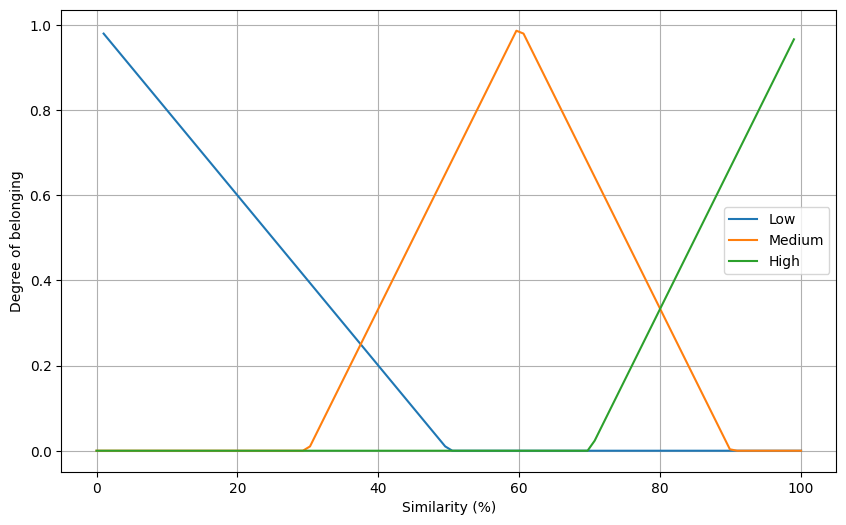

In [ ]:
create_comparison_table(df,threshold=65)
x=np.linspace(0,100,100)
def trimf(x, params):
    a,b,c=params
    return np.maximum(np.minimum((x-a)/(b-a),(c-x)/(c-b)),0)

low=trimf(x,[0,0,50])
medium=trimf(x,[30,60,90])
high=trimf(x,[70,100,100])

plt.figure(figsize=(10,6))
plt.plot(x,low,label='Low')
plt.plot(x,medium,label='Medium')
plt.plot(x,high,label='High')
plt.xlabel('Similarity (%)')
plt.ylabel('Degree of belonging')
plt.legend()
plt.grid(True)
plt.show()